In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 32

In [3]:
df = pd.read_csv('./words_dataset/words_new.txt', sep=' ', comment='#', header=None, on_bad_lines='skip')
df = df[df[1] != 'err']

df = df[df[7] != "*'"]
df = df[df[7] != "**'"]
df = df[df[7] != "&GA"]

df = df[[0, 8]]
df.columns = ['filename', 'word']

vocabulary = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8,
    'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16,
    'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24,
    'Z': 25,
    
    'a': 26, 'b': 27, 'c': 28, 'd': 29, 'e': 30, 'f': 31, 'g': 32, 'h': 33,
    'i': 34, 'j': 35, 'k': 36, 'l': 37, 'm': 38, 'n': 39, 'o': 40, 'p': 41,
    'q': 42, 'r': 43, 's': 44, 't': 45, 'u': 46, 'v': 47, 'w': 48, 'x': 49,
    'y': 50, 'z': 51,
    
    '0': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59,
    '8': 60, '9': 61,
    
    '.': 62, ',': 63, '!': 64, '?': 65, ':': 66, ';': 67, "'": 68, '"': 69,
    '-': 70, '_': 71, '(': 72, ')': 73, '[': 74, ']': 75, '{': 76, '}': 77,
    '/': 78, '\\': 79, '@': 80, '#': 81, '$': 82, '%': 83, '^': 84, '&': 85,
    '*': 86, '+': 87, '=': 88, '|': 89, '~': 90, '`': 91, '<': 92, '>': 93,
    ' ': 94}

inv_vocabulary = {v: k for k, v in vocabulary.items()}

def normalize_image(image, target_size=(256, 64)):
    h, w = image.shape
    scale = min(target_size[1]/h, target_size[0]/w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(image, (new_w, new_h))
    
    # Добавляем паддинг
    delta_w = target_size[0] - new_w
    delta_h = target_size[1] - new_h
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left
    
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, 
                               cv2.BORDER_CONSTANT, value=255)
    return padded

def load_images_and_labels(df, img_folder='./words_dataset/iam_words/words'):
    images = []
    labels = []
    
    c = 0
    k=0
    for idx, row in df.iterrows():
        c+=1
        row_splitted = row['filename'].split('-')[0:2]
        
        img_path = os.path.join(img_folder, row_splitted[0], row_splitted[0]+'-'+row_splitted[1], row['filename'] + '.png')
        if os.path.exists(img_path):
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            img = normalize_image(img)  # Нормализация размера
            images.append(img)
                        
            word = []
            for letter in row['word']:
                word.append(vocabulary[letter])
            
            labels.append(word)
            
    return images, labels

images, labels = load_images_and_labels(df)


27007


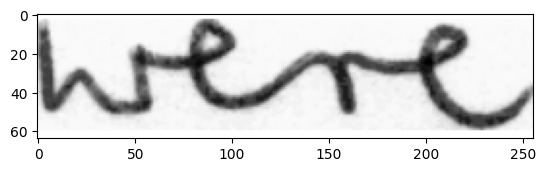

In [3]:
print(len(labels))

plt.imshow(images[1344], cmap='grey')#1235

In [ ]:
# shape0= []
# shape1= []
# length_devided_on_height = []

# for image in images:
#     shape0.append(image.shape[0])
#     shape1.append(image.shape[1])
#     length_devided_on_height.append(image.shape[1]/image.shape[0])
#     if image.shape[1] == 1882:
#         plt.imshow(image)
   
# shapes = pd.DataFrame({'x':shape1, 'y':shape0})
# proportion = pd.Series(length_devided_on_height)
# print(shapes.describe())
# print()
# print(proportion.describe())

# print(shapes['x'])

             x        y
count  27273.0  27273.0
mean     184.0     74.0
std        0.0      0.0
min      184.0     74.0
25%      184.0     74.0
50%      184.0     74.0
75%      184.0     74.0
max      184.0     74.0

count    27273.000000
mean         2.486486
std          0.000000
min          2.486486
25%          2.486486
50%          2.486486
75%          2.486486
max          2.486486
dtype: float64
0        184
1        184
2        184
3        184
4        184
        ... 
27268    184
27269    184
27270    184
27271    184
27272    184
Name: x, Length: 27273, dtype: int64


In [4]:
normalized_images = []
for image in images:
    normalized_images.append((image / 127.5) - 1)


In [7]:
# print(normalized_images[234][30])
print(images[:10])
print(normalized_images[:10])

[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(64, 256), dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(64, 256), dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(64, 256), dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255

In [5]:
x_train_list, x_test_list, y_train_list, y_test_list = train_test_split(normalized_images, labels, train_size=0.7, random_state=42)

x_train_np = [np.array(img, dtype=np.float32) for img in x_train_list]
x_train_np = [img[np.newaxis, :, :] for img in x_train_np]
x_train = torch.stack([torch.from_numpy(img) for img in x_train_np])

x_test_np = [np.array(img, dtype=np.float32) for img in x_test_list]
x_test_np = [img[np.newaxis, :, :] for img in x_test_np]
x_test = torch.stack([torch.from_numpy(img) for img in x_test_np])

y_train = [torch.tensor(label, dtype=torch.long) for label in y_train_list]
y_test = [torch.tensor(label, dtype=torch.long) for label in y_test_list]

y_train_padded = pad_sequence(y_train, batch_first=True, padding_value=-1)
y_test_padded = pad_sequence(y_test, batch_first=True, padding_value=-1)


train_dataset = TensorDataset(x_train, y_train_padded)
test_dataset = TensorDataset(x_test, y_test_padded)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

: 

In [12]:
print(len(x_train), len(x_train[0]), len(x_train[0][0]), len(x_train[0][0][0]))
# print(x_train)
print(len(y_train), len(y_train[0]))
print(y_train_padded)

18904 1 64 256
18904 6
tensor([[11, 26, 27,  ..., -1, -1, -1],
        [44, 45, 40,  ..., -1, -1, -1],
        [31, 40, 43,  ..., -1, -1, -1],
        ...,
        [28, 40, 39,  ..., -1, -1, -1],
        [45, 33, 30,  ..., -1, -1, -1],
        [63, -1, -1,  ..., -1, -1, -1]])


In [ ]:
# def train(model, train_loader, val_loader, num_epochs:int = 70,  patience:int = 5, learning_rate:float = 0.001, plot:bool=True):
    
#     epoch_no_improve = 0
    
#     criterion = nn.CrossEntropyLoss()                      #good for multiclasses classification
#     optimizer = Adam(model.parameters(), lr=learning_rate) #great for most of the tasks
    
#     #verifying if we have GPU\CPU availible to be used 
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)
    
#     history = {'train_loss': [], 'val_loss': [], 'val_accuracy':[]}
#     best_val_loss = float('inf')
    
#     for epoch in range(num_epochs):
#         #training model
#         model.train()
#         current_loss = 0.0
        
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             optimizer.zero_grad()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             loss.backward()
#             optimizer.step()
            
#             current_loss += loss.item()
        
#         #evaluation the result on validation dataset
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
        
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)
                
#                 outputs = model(inputs)
                
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
                
#                 _, predicted_indexes = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 correct += (predicted_indexes == torch.argmax(labels, dim=1)).sum().item()
        
#         #adding the results to history
#         epoch_loss = current_loss / len(train_loader)
#         val_loss = val_loss / len(val_loader)
#         history['train_loss'].append(epoch_loss)
#         history['val_loss'].append(val_loss)
#         history['val_accuracy'].append(correct/total)
        
#         #saving if the model if it performed better than other 
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 'best_model.pth')
#             epoch_no_improve = 0
#         else:
#             epoch_no_improve += 1
        
#         #printing the epoch and the current results to see the progress in time 
#         print(f'Epoch {epoch+1}/{num_epochs}')
#         print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {correct/total:.4f}')
#         print('-' * 50)
    
#         if epoch_no_improve >= patience:
#             print(f"Early stop was triggered")
#             break
            
    
#     #plotting the result of training
#     if plot:
#         plot_model_curves(history)
    
#     #taking the best model from the file
#     model.load_state_dict(torch.load('best_model.pth'))
#     return model, history

In [ ]:
# def test(model, test_loader, plot: bool=True):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     criterion = nn.CrossEntropyLoss()   #good for multiclass classification

#     model.eval()
#     test_loss = 0
#     total = 0
#     correct = 0
    
#     all_preds = []
#     all_labels =[]
    
#     #testing the model on the test dataset    
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)
            
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
            
#             _, predicted_indexes = torch.max(outputs.data, 1)
    
#             all_preds.extend(predicted_indexes.numpy())
#             all_labels.extend(torch.argmax(labels, dim=1))
            
#             total += labels.size(0)
#             correct += (predicted_indexes == torch.argmax(labels, dim=1)).sum().item()
    
#     #calculating the result
#     test_loss = test_loss / len(test_loader)
#     test_accuracy = correct / total

#     #plotting the confusion matrix 
#     if plot:
#         plot_model_confusion_matrix(test_loss, test_accuracy, all_preds, all_labels)    
#     return test_loss, test_accuracy
    

In [ ]:
# class CNN_2D(nn.Module):
#     def __init__(self, kernel_padding:tuple=(5, 2), conv_layer_outs:list=[64, 128]):
#         super(CNN_2D, self).__init__()
        
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=3,
#                 out_channels=conv_layer_outs[0],
#                 kernel_size=kernel_padding[0],
#                 padding=kernel_padding[1],
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#         )
        
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=conv_layer_outs[0],
#                 out_channels=conv_layer_outs[-1],
#                 kernel_size=kernel_padding[0],
#                 padding=kernel_padding[1],
#             ),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),
#         )
        
#         self.out = nn.Sequential(
#             nn.Dropout(p=0.3),
#             nn.Linear(conv_layer_outs[-1] * 6 * 6, conv_layer_outs[-1] * 6),
#             nn.ReLU(),
#             nn.Linear(conv_layer_outs[-1] * 6, conv_layer_outs[-1]*3),
#             nn.ReLU(),
#             nn.Linear(conv_layer_outs[-1] * 3, conv_layer_outs[-1]),
#             nn.ReLU(),
#             nn.Linear(conv_layer_outs[-1], 64),
#             nn.ReLU(),
#             nn.Linear(64, 4)
#         )
        
#     def forward(self, x):
#         #(batch_size, 3, 24, 24)->(batch_size, 64, 12, 12)
#         x = self.conv1(x)
#         #(batch_size, 64, 12, 12)->(batch_size, 128, 6, 6)
#         x = self.conv2(x)
#         x = x.view(x.size(0), -1)
#         x = self.out(x)
#         return x

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=5,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 64, 256)
            dummy = self.conv1(dummy)
            dummy = self.conv2(dummy)
            self.output_height = dummy.size(2)
            self.output_width = dummy.size(3)
            self.num_features = dummy.size(1) * dummy.size(2)
        
        self.linear = nn.Linear(self.num_features, len(vocabulary) + 1)  # +1 для blank token
        
        
        
        # self.linear = nn.Linear(64*16*64, len(vocabulary))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.linear(x)
        # print(x.shape)
        
        # Изменение размерности для линейного слоя
        batch_size = x.size(0)
        x = x.permute(0, 3, 2, 1)  # [B, W, H, C]
        x = x.contiguous().view(batch_size, self.output_width, -1)  # [B, W, H*C]
        
        # Линейный слой
        x = self.linear(x)  # [B, W, num_chars + 1]
        return x

In [8]:
def train(model, train_loader, num_epochs:int = 70,  patience:int = 5, learning_rate:float = 0.001):
    
    epoch_no_improve = 0
    
    criterion = nn.CTCLoss(blank=len(vocabulary))
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(num_epochs):
        #training model
        model.train()
        current_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            
            labels_lengths = torch.tensor([len(t[t != -1]) for t in labels])
            
            # labels_no_pad = []
            
            # for i in range(len(labels)):
            #     labels_no_pad.append(labels[i][:labels_lengths[i]])
        
            labels = labels[labels != -1]  # Удаляем padding


            optimizer.zero_grad()

            outputs = model(inputs)
            log_probs = torch.log_softmax(outputs, dim=2)
            
            input_lengths = torch.full(
            size=(outputs.size(0),), 
            fill_value=outputs.size(1), 
            dtype=torch.long
            )
            
            
            loss = criterion(
                log_probs.permute(1, 0, 2),
                labels,
                input_lengths,
                labels_lengths
            )
            
            loss.backward()
            optimizer.step()
            
            current_loss += loss.item()
            print("input processed")
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save(model.state_dict(), 'best_model.pth')
        #     epoch_no_improve = 0
        # else:
        #     epoch_no_improve += 1
        
        #printing the epoch and the current results to see the progress in time 
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {current_loss:.4f}')
        print('-' * 50)
    
        if epoch_no_improve >= patience:
            print(f"Early stop was triggered")
            break
    
    #taking the best model from the file
    # model.load_state_dict(torch.load('best_model.pthistoryh'))
    return model

    

In [9]:
model = CNN()
train(model, train_loader=train_loader)

input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input processed
input pr

KeyboardInterrupt: 